# Chapter 3 Exercises

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Simulate and forecast a random walk
Simulate a different random walk than the one we have worked with in this chapter.
You can simply change the seed and get new values:

1. Generate a random walk of 500 timesteps. Feel free to choose an initial value
different from 0. Also, make sure you change the seed by passing a different
integer to `np.random.seed()`.
2. Plot your simulated random walk.
3. Test for stationarity.
4. Apply a first-order difference.
5. Test for stationarity.
6. Split your simulated random walk into a train set containing the first 400 timesteps. The remaining 100 timesteps will be your test set.
7. Apply different naive forecasting methods and measure the MSE. Which
method yields the lowest MSE?
8. Plot your forecasts.
9. Forecast the next timestep over the test set and measure the MSE. Did it decrease?
10. Plot your forecasts.

**Generate a random walk of 500 timesteps. Feel free to choose an initial value different from 0.**

In [5]:
np.random.seed(40)

steps = np.random.standard_normal(500)   # Generate 500 random numbers from a standard normal distribution (mean=0, std=1)
steps[0] = 10                            # Initial value = 10

random_walk = np.cumsum(steps)           # Calculate the cumulative sum of the steps to simulate the random walk

random_walk[:10]                         # First 10 values

array([10.        ,  9.87386359,  9.18925723, 10.11797198,  8.27357094,
        7.80656852, 10.09905886, 10.58786891, 11.29813591, 12.35367035])

**Plot your simulated random walk.**

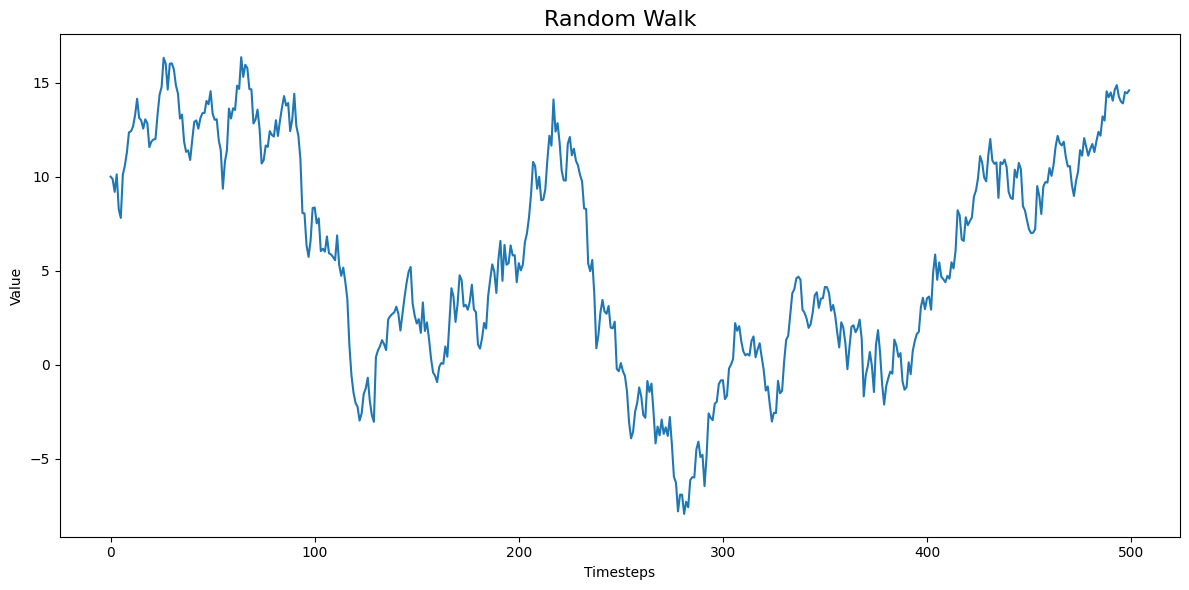

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Random Walk', fontsize=16)

plt.tight_layout()

**Test for stationarity.**

In [9]:
# Augmented Dickey Fuller (ADF): Not stationary (H0), Stationary (Ha)

ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5913356419504012
p-value: 0.4879444456632103


    p-value (0.488) > alpha (0.05); H0: Not stationary

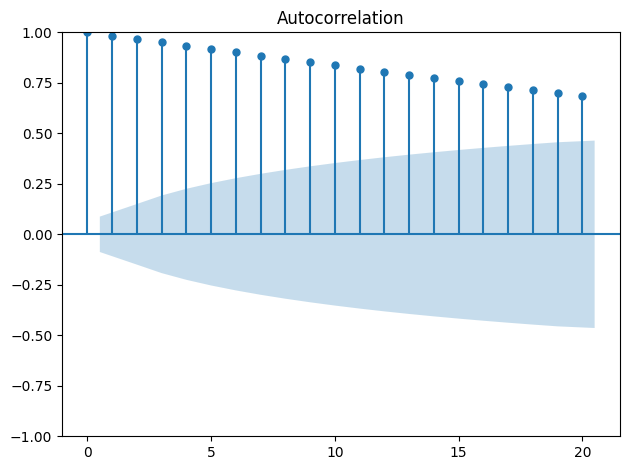

In [11]:
# Auto Correlation Function
plot_acf(random_walk, lags=20);

plt.tight_layout()

**Apply a first-order difference.**

In [13]:
# Detrending
diff_random_walk = np.diff(random_walk, n=1) # First-order differencing

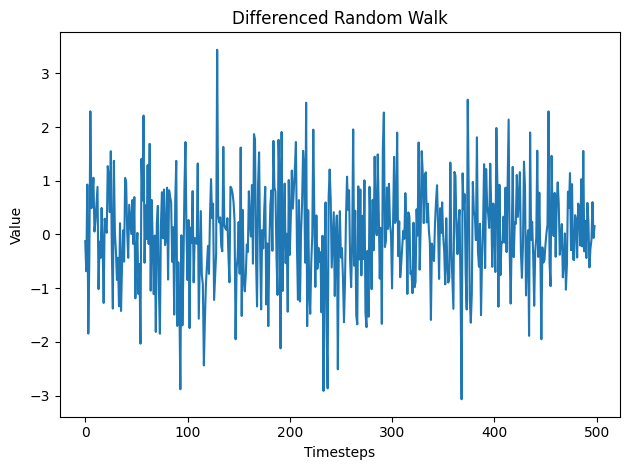

In [14]:
plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

**Test for stationarity.**

In [16]:
# Augmented Dickey Fuller's test for 'diff_random_walk' 
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -21.973525117525824
p-value: 0.0


    p-value (0.00) < alpha (0.05); Ha: Stationary

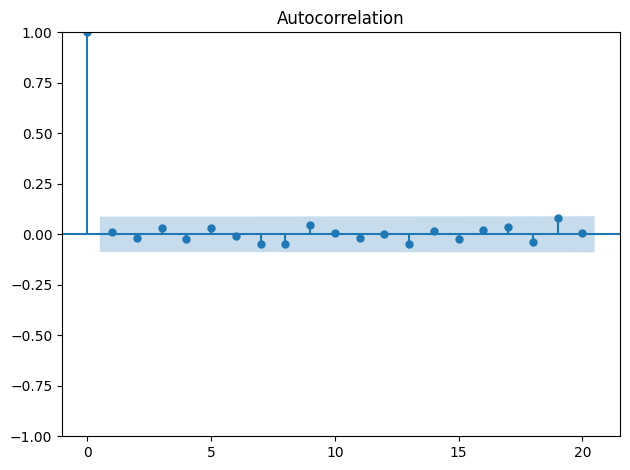

In [18]:
# Plot Auto Correlation Function
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

**Split your simulated random walk into a train set containing the first 400 timesteps. The remaining 100 timesteps will be your test set.**

In [20]:
df = pd.DataFrame({'value': random_walk})

train = df[:400] # The first 80% of the data is assigned to the train set.
test = df[400:]  # Assign the last 20% of the data as test set

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   400 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 400 to 499
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   100 non-null    float64
dtypes: float64(1)
memory usage: 932.0 bytes


**Apply different naive forecasting methods and measure the MSE. Which method yields the lowest MSE?**

In [24]:
mean = np.mean(train.value)              # Calculate the mean of the train set
test.loc[:, 'pred_mean'] = mean          # Predict the historical mean for the next 100 timesteps

last_value = train.iloc[-1].value        # Retrieve the last value of the train set
test.loc[:, 'pred_last'] = last_value    # Assign the last value as a prediction for the next 100 timesteps under the pred_last column

deltaX = 400 - 1                         # Calculate the difference in X (400 - 1)
deltaY = last_value - 0                  # Calculate the difference in Y (last_value - 0)
drift = deltaY / deltaX                  # Calculate the drift (slope) using deltaY and deltaX
x_vals = np.arange(401, 501, 1)          # Generate an array of x values from 401 to 500 (inclusive)
pred_drift = drift * x_vals              # Multiply the drift by each value in x_vals to get the predicted drift
test.loc[:, 'pred_drift'] = pred_drift   # Add the predicted drift values as a new column in the 'test' DataFrame

test.head()                              # Show the first five rows of test

,value,pred_mean,pred_last,pred_drift
400,3.535928,4.571965,2.960159,2.974997
401,3.627021,4.571965,2.960159,2.982416
402,2.928230,4.571965,2.960159,2.989835
403,4.910073,4.571965,2.960159,2.997254
404,5.861157,4.571965,2.960159,3.004672


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 400 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       100 non-null    float64
 1   pred_mean   100 non-null    float64
 2   pred_last   100 non-null    float64
 3   pred_drift  100 non-null    float64
dtypes: float64(4)
memory usage: 3.3 KB


In [26]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(f'      MSE for mean: {mse_mean}')
print(f'MSE for last value: {mse_last}')
print(f'     MSE for drift: {mse_drift}')

      MSE for mean: 34.90129556985135
MSE for last value: 54.07514083616252
     MSE for drift: 48.0431706501223


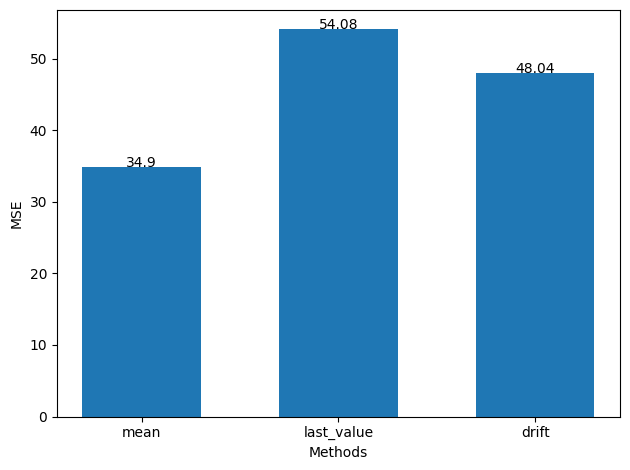

In [27]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(round(value, 2)), ha='center')

plt.tight_layout()

Lowest MSE: **Mean** Naive Forecasting

**Plot your forecasts.**

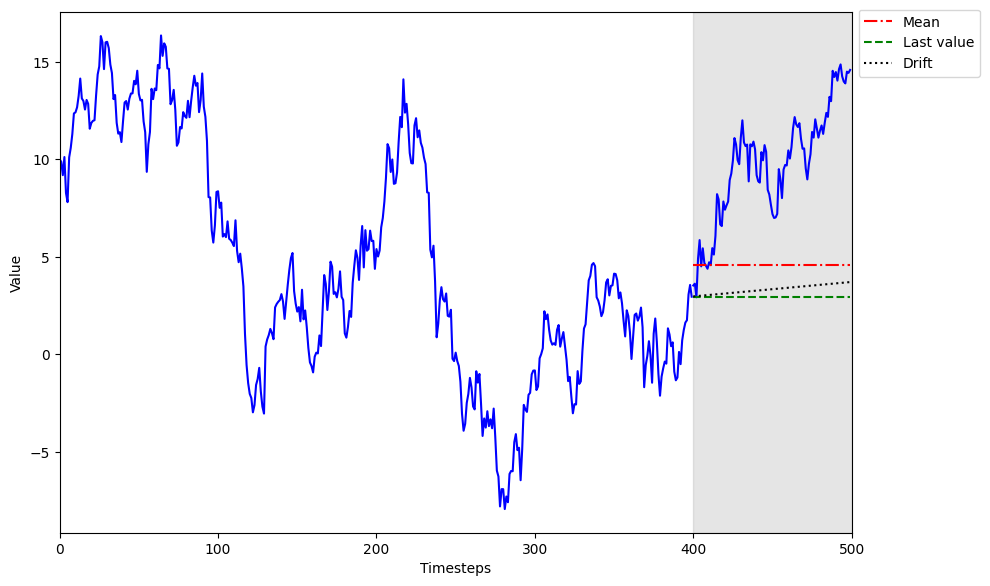

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))                # Create a new figure and axis for the plot

ax.plot(train.value, 'b-')                             # Plot the 'value' column from the 'train' DataFrame with a blue solid line
ax.plot(test['value'], 'b-')                           # Plot the 'value' column from the 'test' DataFrame with a blue solid line
ax.plot(test['pred_mean'], 'r-.', label='Mean')        # Plot the predicted mean with a red dash-dot line and label it as 'Mean'
ax.plot(test['pred_last'], 'g--', label='Last value')  # Plot the predicted last value with a green dashed line and label it as 'Last value'
ax.plot(test['pred_drift'], 'k:', label='Drift')       # Plot the predicted drift with a black dotted line and label it as 'Drift'

ax.axvspan(400, 500, color='#808080', alpha=0.2)       # Highlight the region from x=400 to x=500 with a gray shaded area

ax.legend(loc='center left', bbox_to_anchor=(1, 0.94)) # Place the legend outside the plot on the right
ax.set_xlim(0, 500)                                    # Set X-axis limits

ax.set_xlabel('Timesteps')                             # Set the label for the x-axis
ax.set_ylabel('Value')                                 # Set the label for the y-axis

plt.tight_layout()                                     # Adjust the plot to ensure that all elements fit without overlap

**Forecast the next timestep over the test set and measure the MSE. Did it decrease?**

In [32]:
df.head()

,value
0,10.000000
1,9.873864
2,9.189257
3,10.117972
4,8.273571


In [33]:
df_shift = df.shift(periods=1)  # Next timestep

df_shift.head()

,value
0,NaN
1,10.000000
2,9.873864
3,9.189257
4,10.117972


In [34]:
mse_one_step = mean_squared_error(test['value'], df_shift[400:])

print("MSE for one_step:",mse_one_step)

MSE for one_step: 0.670898152293387


In [35]:
print(f'      MSE for mean: {mse_mean}')
print(f'MSE for last value: {mse_last}')
print(f'     MSE for drift: {mse_drift}')

      MSE for mean: 34.90129556985135
MSE for last value: 54.07514083616252
     MSE for drift: 48.0431706501223


It decreased significantly.

**Plot your forecasts.**

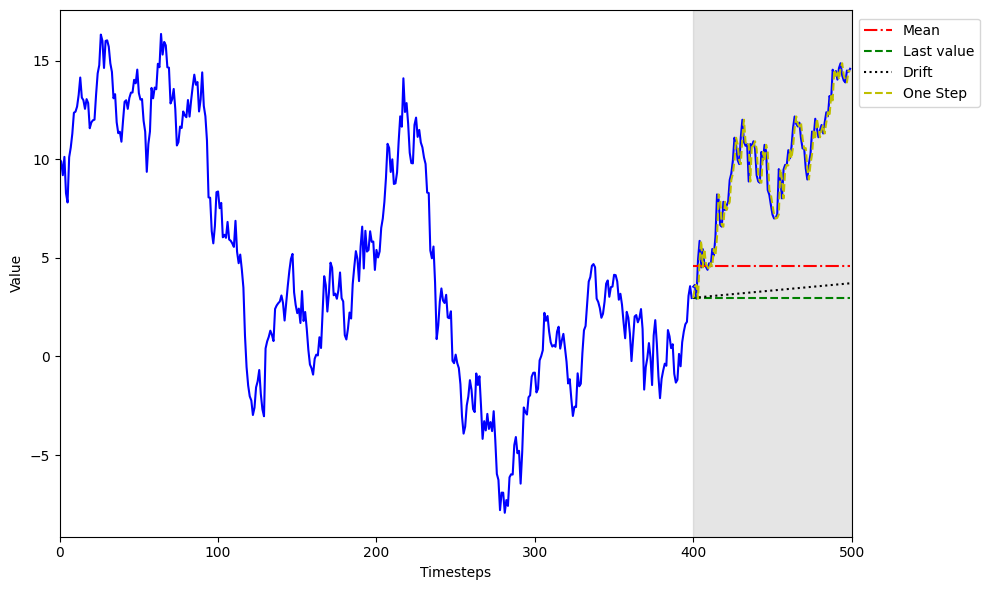

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))                # Create a new figure and axis for the plot

ax.plot(train.value, 'b-')                             # Plot the 'value' column from the 'train' DataFrame with a blue solid line
ax.plot(test['value'], 'b-')                           # Plot the 'value' column from the 'test' DataFrame with a blue solid line
ax.plot(test['pred_mean'], 'r-.', label='Mean')        # Plot the predicted mean with a red dash-dot line and label it as 'Mean'
ax.plot(test['pred_last'], 'g--', label='Last value')  # Plot the predicted last value with a green dashed line and label it as 'Last value'
ax.plot(test['pred_drift'], 'k:', label='Drift')       # Plot the predicted drift with a black dotted line and label it as 'Drift'
ax.plot(df_shift[400:], 'y--', label='One Step')       # Plot the predicted drift with a yellow dashed line and label it as 'One Step'

ax.axvspan(400, 500, color='#808080', alpha=0.2)       # Highlight the region from x=400 to x=500 with a gray shaded area

ax.legend(loc='center left', bbox_to_anchor=(1, 0.90)) # Place the legend outside the plot on the right
ax.set_xlim(0, 500)                                    # Set X-axis limits

ax.set_xlabel('Timesteps')                             # Set the label for the x-axis
ax.set_ylabel('Value')                                 # Set the label for the y-axis

plt.tight_layout()                                     # Adjust the plot to ensure that all elements fit without overlap

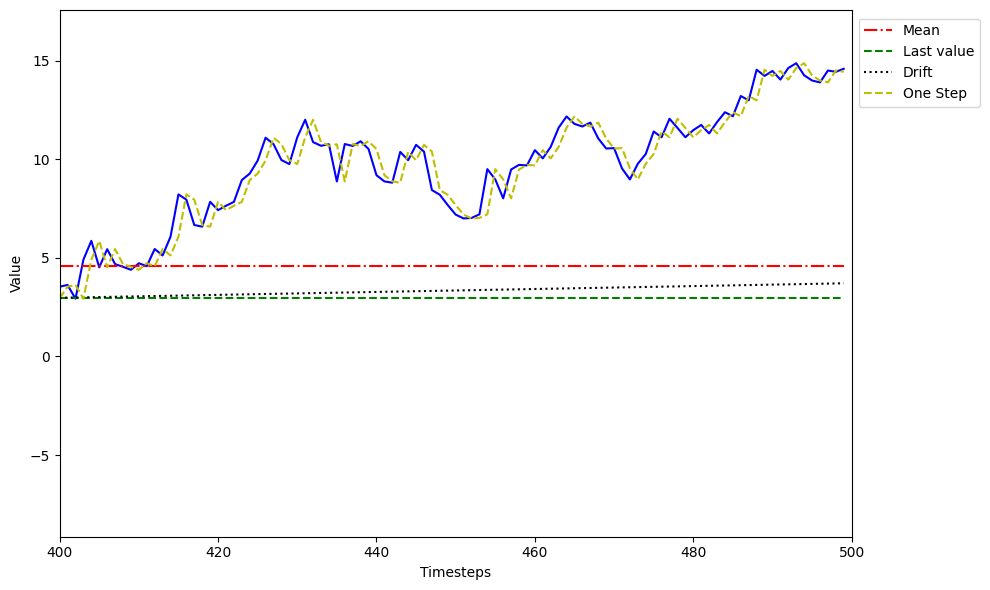

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))                # Create a new figure and axis for the plot

ax.plot(train.value, 'b-')                             # Plot the 'value' column from the 'train' DataFrame with a blue solid line
ax.plot(test['value'], 'b-')                           # Plot the 'value' column from the 'test' DataFrame with a blue solid line
ax.plot(test['pred_mean'], 'r-.', label='Mean')        # Plot the predicted mean with a red dash-dot line and label it as 'Mean'
ax.plot(test['pred_last'], 'g--', label='Last value')  # Plot the predicted last value with a green dashed line and label it as 'Last value'
ax.plot(test['pred_drift'], 'k:', label='Drift')       # Plot the predicted drift with a black dotted line and label it as 'Drift'
ax.plot(df_shift[400:], 'y--', label='One Step')       # Plot the predicted drift with a yellow dashed line and label it as 'One Step'

ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))  # Place the legend outside the plot on the right
ax.set_xlim(400, 500)                                  # Set X-axis limits

ax.set_xlabel('Timesteps')                             # Set the label for the x-axis
ax.set_ylabel('Value')                                 # Set the label for the y-axis

plt.tight_layout()                                     # Adjust the plot to ensure that all elements fit without overlap

## Forecast the daily closing price of GOOGL
Using the GOOGL dataset that we worked with in this chapter, apply the forecasting
techniques we’ve discussed and measure their performance:

1. Keep the last 5 days of data as a test set. The rest will be the train set.
2. Forecast the last 5 days of the closing price using naive forecasting methods and
measure the MSE. Which method is the best?
3. Plot your forecasts.
4. Forecast the next timestep over the test set and measure the MSE. Did it
decrease?
5. Plot your forecasts.

In [41]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/GOOGL.csv')
df = pd.read_csv(url1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


**Keep the last 5 days of data as a test set. The rest will be the train set.**

In [43]:
# Keep the last five days to test the forecasts

googl_train = df[['Date','Close']][:-5]
googl_test = df[['Date','Close']][-5:]

googl_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    248 non-null    object 
 1   Close   248 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [44]:
googl_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 248 to 252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5 non-null      object 
 1   Close   5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 212.0+ bytes


**Forecast the last 5 days of the closing price using naive forecasting methods and measure the MSE. Which method is the best?**

In [46]:
# Forecast the historical mean
mean = np.mean(googl_train['Close'])
googl_test.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = googl_train['Close'].iloc[-1]
googl_test.loc[:, 'pred_last'] = last_value

# Forecast using the drift
deltaX = len(googl_train)                                     # The deltaX is basically the length of the training set
deltaY = last_value - googl_train['Close'].iloc[0]            # Remember to subtract the initial value of the training set
drift = deltaY / deltaX                                       # Calculate the drift (slope) using deltaY and deltaX
x_vals = np.arange(248, 253, 1)                               # Generate array with all values
pred_drift = drift * x_vals + googl_train['Close'].iloc[0]    # Add the initial value back in the predictions
googl_test.loc[:, 'pred_drift'] = pred_drift                  # Add the predicted drift values as a new column in the 'test' DataFrame

googl_test

,Date,Close,pred_mean,pred_last,pred_drift
248,2021-04-21,2278.350098,1689.993184,2279.01001,2279.010010
249,2021-04-22,2252.520020,1689.993184,2279.01001,2283.075131
250,2021-04-23,2299.929932,1689.993184,2279.01001,2287.140252
251,2021-04-26,2309.929932,1689.993184,2279.01001,2291.205373
252,2021-04-27,2290.979980,1689.993184,2279.01001,2295.270494


In [47]:
from sklearn.metrics import mean_squared_error

googl_mse_mean = mean_squared_error(googl_test['Close'], googl_test['pred_mean'])
googl_mse_last = mean_squared_error(googl_test['Close'], googl_test['pred_last'])
googl_mse_drift = mean_squared_error(googl_test['Close'], googl_test['pred_drift'])

print(f'      MSE for mean: {googl_mse_mean}')
print(f'MSE for last value: {googl_mse_last}')
print(f'     MSE for drift: {googl_mse_drift}')

      MSE for mean: 356025.96701539395
MSE for last value: 447.82398976418415
     MSE for drift: 293.3287644069853


The best method is "Drift"

**Plot your forecasts.**

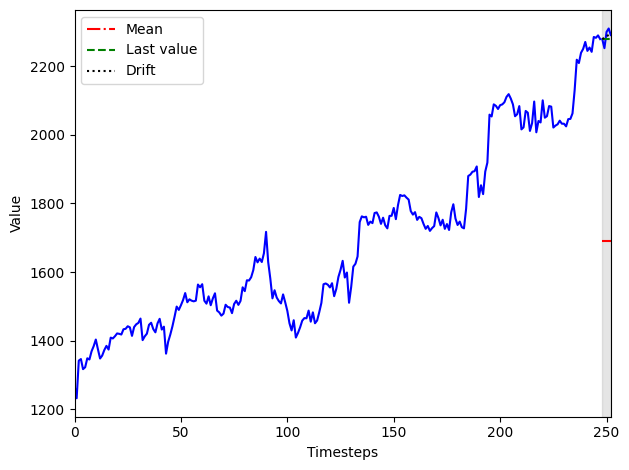

In [50]:
fig, ax = plt.subplots()

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 252)
plt.tight_layout()

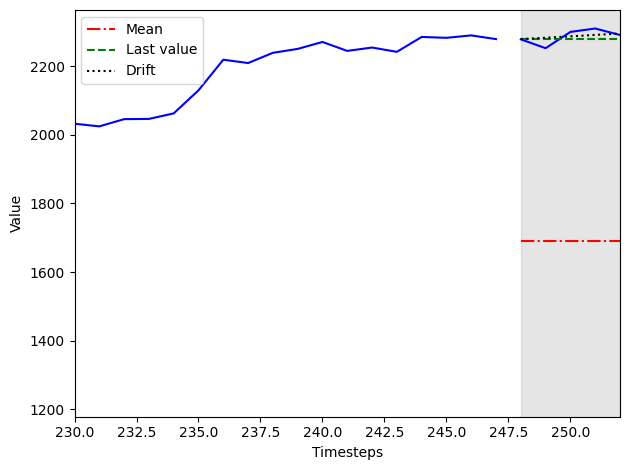

In [51]:
fig, ax = plt.subplots()

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(230, 252)
plt.tight_layout()

**Forecast the next timestep over the test set and measure the MSE. Did it decrease?**

In [53]:
# Forecast the next timestep
df_shift = df.shift(periods=1)

mse_one_step = mean_squared_error(googl_test['Close'], df_shift['Close'].iloc[248:])

print("MSE for one_step:",mse_one_step)

MSE for one_step: 674.8857699967758


In [54]:
print(f'      MSE for mean: {googl_mse_mean}')
print(f'MSE for last value: {googl_mse_last}')
print(f'     MSE for drift: {googl_mse_drift}')

      MSE for mean: 356025.96701539395
MSE for last value: 447.82398976418415
     MSE for drift: 293.3287644069853


    NO. 674.89 > 293.33

**Plot your forecasts.**

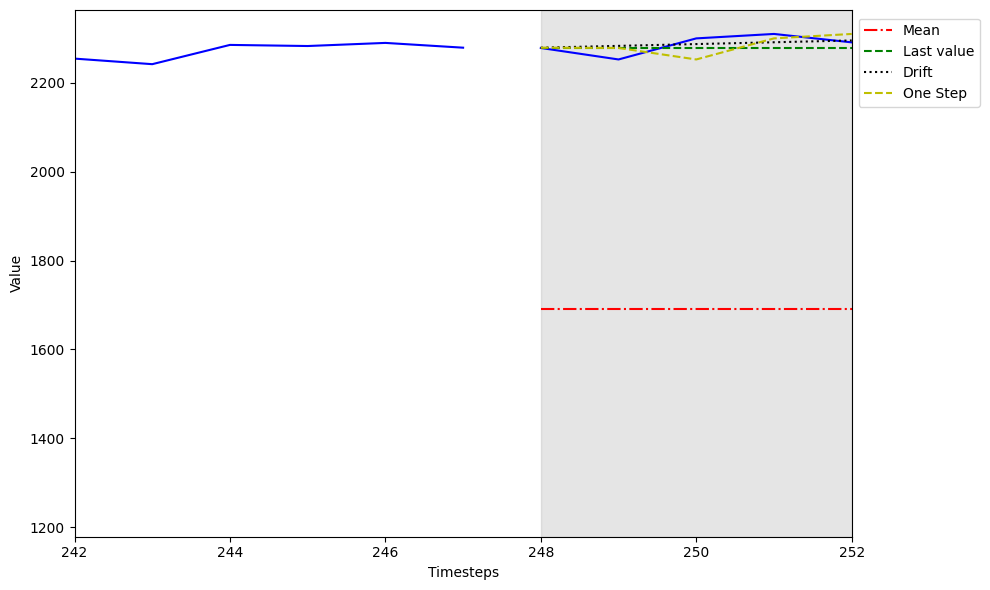

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')
ax.plot(df_shift['Close'].iloc[248:], 'y--', label='One Step') 

ax.legend(loc='center left', bbox_to_anchor=(1, 0.9)) 

ax.axvspan(248, 252, color='#808080', alpha=0.2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(242, 252)
plt.tight_layout()